In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter
import xgboost as xgb
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd

from tst import Transformer
import os
import pandas as pd
import torch.nn as nn

In [3]:
path = '/share/data/willett-group/'


us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []

# target location
tar_lat = 33.75
tar_lon = 242.25

for i in range(1985,2019): #(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index() # precipitation
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
#     sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
#     sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index() # Daily geopotential height at 10mb and 500mb
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index() # Daily relative humidity near the surface
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index() # Daily average temperature at 2 meters
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
#     print('original', tmp2m.shape)
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
#     print('after merge', tmp2m.shape)
    
#     hgt = np.reshape(hgt[(hgt['lat']==25.25) & (hgt['lon']==279.25)].hgt.to_numpy(),(-1,1))
#     rhum = np.reshape(rhum[(rhum['lat']==25.25) & (rhum['lon']==279.25)].rhum.to_numpy(),(-1,1))
#     tmp2m = np.reshape(tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)].tmp2m.to_numpy(),(-1,1))
    hgt = np.reshape(hgt[(hgt['lat']==tar_lat) & (hgt['lon']==tar_lon)].hgt.to_numpy(),(-1,1))
    hgt = hgt[:365]
    rhum = np.reshape(rhum[(rhum['lat']==tar_lat) & (rhum['lon']==tar_lon)].rhum.to_numpy(),(-1,1))
    rhum = rhum[:365]
    precip = np.reshape(precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip.to_numpy(),(-1,1))
    precip = precip[:365]
    
    y_samp = y_samp.append(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m[:365],ignore_index=True)
    
    tmp2m = np.reshape(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m.to_numpy(),(-1,1))
    tmp2m = tmp2m[:365]
    
#     y_samp.append(tmp2m)
    #y_samp = y_samp.append(precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip,ignore_index=True)
    print('one location', tmp2m.shape)
    
#     y_samp = y_samp.append(precip[precip['lat']==25.25].precip,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
#     temp = sst #sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
#     print(temp.shape)
#     sst_samp = temp.sst.reset_index().sst.to_numpy()
#     print(sst_samp.shape)
#     size = int(len(sst_samp)/days)
#     sst_samp = np.reshape(sst_samp,(size, days)).transpose() # days as rows, different locations as columns
#     if sst_samp.shape[0] == tmp2m.shape[0]:
#         all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
#     else:
#         sst_samp = sst_samp[:365]
#         hgt = hgt[:365]
#         rhum = rhum[:365]
#     sst_samp = sst_samp[:365]
    tmp2m = tmp2m[:365]
    hgt = hgt[:365]
    rhum = rhum[:365]
    all_features = np.concatenate((hgt, rhum, precip),axis=1)
    print('all_features', all_features.shape)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1, X_size)) #  For concatenating all data
print(X_samp.shape)
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp, X_total[i]), axis = 0)
X_samp = X_samp[1:]
print(X_samp.shape)

<ipython-input-3-4768dff50e72>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.1985.h5
one location (365, 1)
all_features (365, 3)
precip.1986.h5
one location (365, 1)
all_features (365, 3)
precip.1987.h5
one location (365, 1)
all_features (365, 3)
precip.1988.h5
one location (365, 1)
all_features (365, 3)
precip.1989.h5
one location (365, 1)
all_features (365, 3)
precip.1990.h5
one location (365, 1)
all_features (365, 3)
precip.1991.h5
one location (365, 1)
all_features (365, 3)
precip.1992.h5
one location (365, 1)
all_features (365, 3)
precip.1993.h5
one location (365, 1)
all_features (365, 3)
precip.1994.h5
one location (365, 1)
all_features (365, 3)
precip.1995.h5
one location (365, 1)
all_features (365, 3)
precip.1996.h5
one location (365, 1)
all_features (365, 3)
precip.1997.h5
one location (365, 1)
all_features (365, 3)
precip.1998.h5
one location (365, 1)
all_features (365, 3)
precip.1999.h5
one location (365, 1)
all_features (365, 3)
precip.2000.h5
one location (365, 1)
all_features (365, 3)
precip.2001.h5
one location (365, 1)
all_features (365, 

Data downloaded. This piece of code download data for one location but no sst. So, it should return (len_years, 3), where 3 features correspond to hgt, rhum, precip. For example, for 1 year it return X of shape (365, 3). y would be (365) -- temperature (target) 

In [4]:
X_copy = X_samp.copy()
y_copy = y_samp.copy()

# X_samp = X_copy.copy()
# y_samp = y_copy.copy()
# target = 'precip'

# y_samp = X_copy[:,X_copy.shape[1]-1].copy()
# X_samp[:,X_copy.shape[1]-1] = y_copy[:-1].copy() #.copy()
target = 'tmp2m'

In [5]:
X_copy.shape # length, features 3: hgt, rhum, precip

(12410, 3)

In [6]:
y_samp.shape # target tmp2m

(12410,)

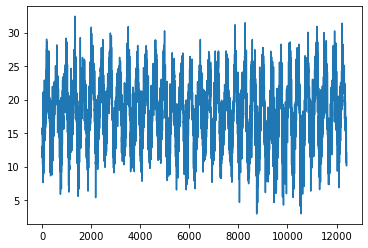

In [7]:
plt.plot(y_samp);

In [8]:
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [9]:
X_samp.shape, y_samp.shape

((12396, 3), (12396,))

In [10]:
X = X_samp.copy()
y = y_samp.copy()

In [11]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [12]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 

In [13]:
# use for TRANSFORMER!
M = np.max(y_train)
m = np.min(y_train)
y_train = (y_train -m)/(M - m)

X_train_max_0 = np.max(X_train[:,0])
X_train_min_0 = np.min(X_train[:,0])
X_train[:,0] = (X_train[:,0] - np.min(X_train[:,0]))/ (np.max(X_train[:,0]) - np.min(X_train[:,0]))

X_train_max_1 = np.max(X_train[:,1])
X_train_min_1 = np.min(X_train[:,1])
X_train[:,1] = (X_train[:,1] - np.min(X_train[:,1]))/(np.max(X_train[:,1]) - np.min(X_train[:,1]))

X_train_max_2 = np.max(X_train[:,2])
X_train_min_2 = np.min(X_train[:,2])
X_train[:,2] = (X_train[:,2] - np.min(X_train[:,2]))/(np.max(X_train[:,2]) - np.min(X_train[:,2]))

# X_train_max_3 = np.max(X_train[:,3])
# X_train_min_3 = np.min(X_train[:,3])
# X_train[:,3] = (X_train[:,3] - np.min(X_train[:,3]))/(np.max(X_train[:,3]) - np.min(X_train[:,3]))

In [14]:
print(y_train.max(), y_train.min())
print(X_train.max(), X_train.min())

1.0 0.0
1.0 0.0


In [15]:
y_test = (y_test -m)/(M - m)
X_test[:,0] = (X_test[:,0] - X_train_min_0)/ (X_train_max_0 - X_train_min_0)
X_test[:,1] = (X_test[:,1] - X_train_min_1)/(X_train_max_1 - X_train_min_1)
X_test[:,2] = (X_test[:,2] - X_train_min_2)/ (X_train_max_2 - X_train_min_2)
# X_test[:,3] = (X_test[:,3] - X_train_min_3)/(X_train_max_3 - X_train_min_3)

In [16]:
print(y_test.max(), y_test.min())
print(X_test.max(), X_test.min())

0.9824147388076973 -0.005940050723798678
1.0197713628210308 -0.02969096557274323


In [144]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9917, 3), (2479, 3), (9917, 1), (2479, 1))

In [17]:
sst_train_pca = np.load('data/sst_train_10pc_new.npy')
sst_test_pca = np.load('data/sst_test_10pc_new.npy')

In [18]:
sst_train_pca.shape, sst_test_pca.shape

((9917, 10), (2479, 10))

In [19]:
X_train.shape, y_test.shape

((9917, 3), (2479, 1))

In [23]:
# y_train = y_train.to('cpu')

In [20]:
train_data_array = np.concatenate((sst_train_pca, X_train, y_train), axis=1)

In [21]:
X_test.shape

(2479, 3)

In [24]:
test_data_array = np.concatenate((sst_test_pca, X_test, y_test), axis=1)

In [25]:
test_data_array.shape

(2479, 14)

In [26]:
class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators


        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [27]:
mdl = XGBoost(num_models=1, n_jobs=1)

In [28]:
# y_train = y_train.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [29]:
mdl.fit(train_data_array, y_train)

[09:03:26] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[09:03:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:03:37] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_gpus=1, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, silent=True, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)]

In [30]:
pred_train = mdl.predict(train_data_array)
pred_test = mdl.predict(test_data_array)

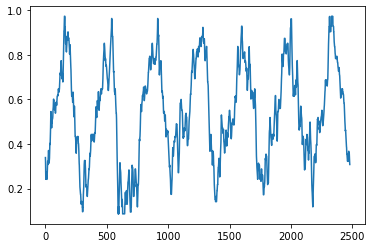

In [31]:
plt.plot(pred_test)

r-sq on train: 0.999879339480477
r-sq on test: 0.9993793108686422
cosine_similarity on train: [[0.99999219]]
cosine_similarity on test: [[0.99995478]]


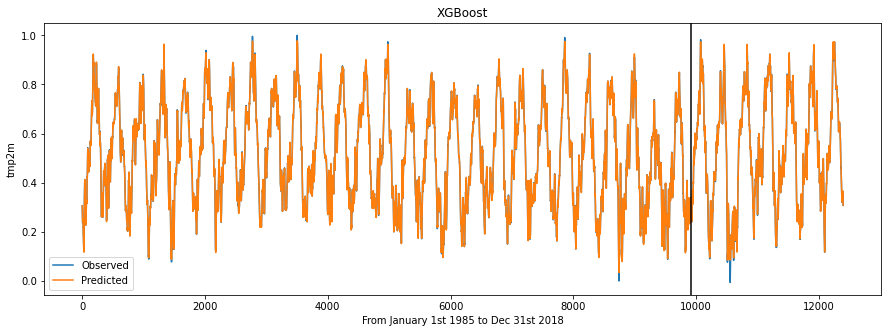

In [32]:
# train_window = 90
print('r-sq on train:', r2_score(y_train, pred_train))
print('r-sq on test:', r2_score(y_test,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost')
plt.axvline(x=X.shape[0]- test_size,c='black');

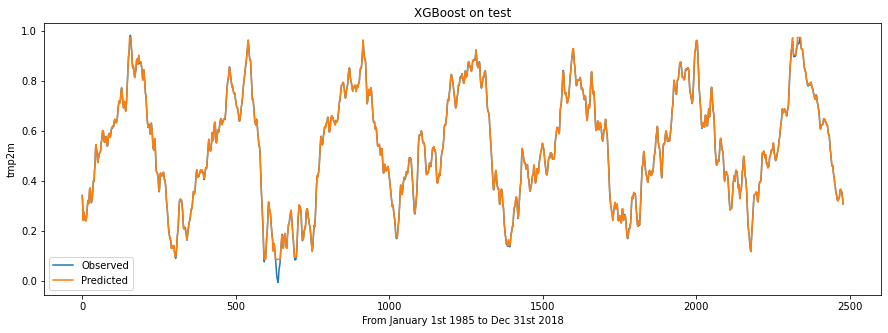

In [33]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(pred_test,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test');

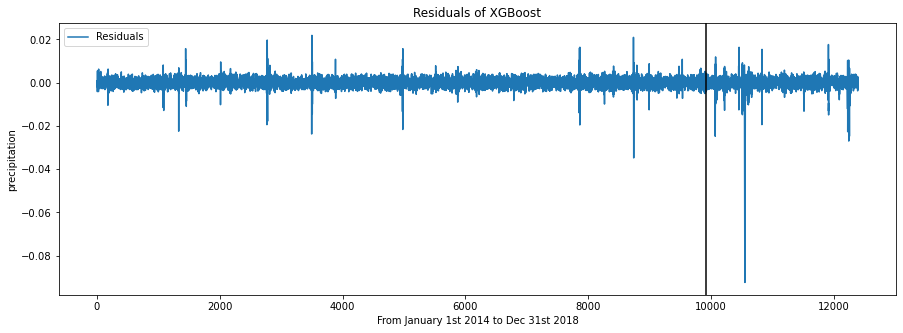

In [34]:
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)) - np.concatenate((pred_train, pred_test)) ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel('precipitation')
plt.title('Residuals of XGBoost');
plt.axvline(x=X.shape[0]- test_size,c='black');

In [35]:
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [36]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)
y_train = y_train.to(device)

In [37]:
def create_sequence(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [38]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 14
train_seq, train_label torch.Size([90, 14]) torch.Size([])


In [39]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [40]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [41]:
d_input = 14 # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-4 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

In [42]:
d_input

14

[Epoch  55/55]: 100%|██████████| 9799/9799 [00:07<00:00, 1293.41it/s, loss=0.00486]


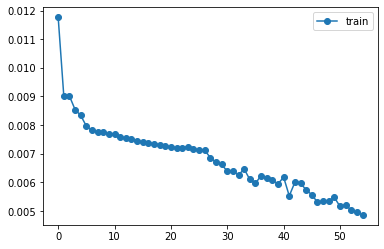

In [43]:
EPOCHS = 55
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [44]:
# test_data = np.concatenate((test_data_new, y_test),axis=1)

train_test_total = np.concatenate((train_data_array, test_data_array))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12306/12306 [04:38<00:00, 44.16it/s]


In [45]:
y_all = np.concatenate((y_train.cpu(), y_test))

r-sq on train: 0.8701521178109216
r-sq on test: 0.8102458745771689
cosine_similarity on train: [[0.99174484]]
cosine_similarity on test: [[0.98626275]]


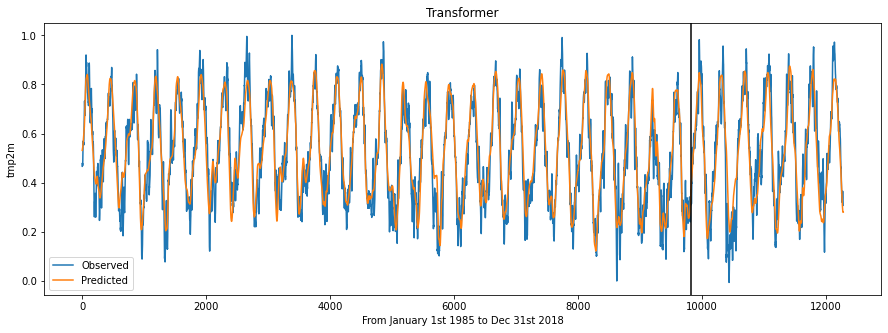

In [46]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.8701521178109216
r-sq on test: 0.8102458745771689
cosine_similarity on train: [[0.99174484]]
cosine_similarity on test: [[0.98626275]]


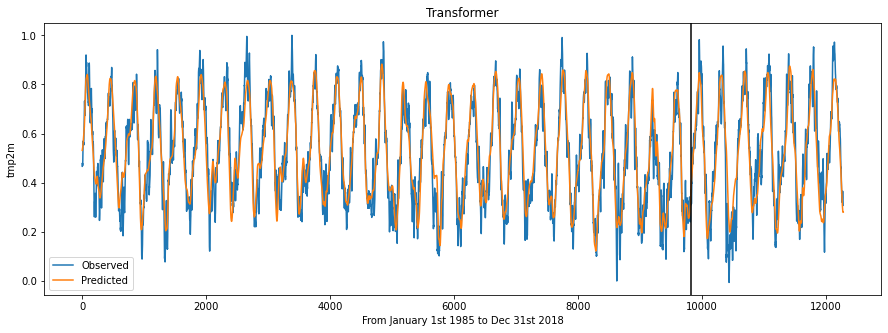

In [53]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');
# plt.savefig('images/transf_30years_10pc.pdf')

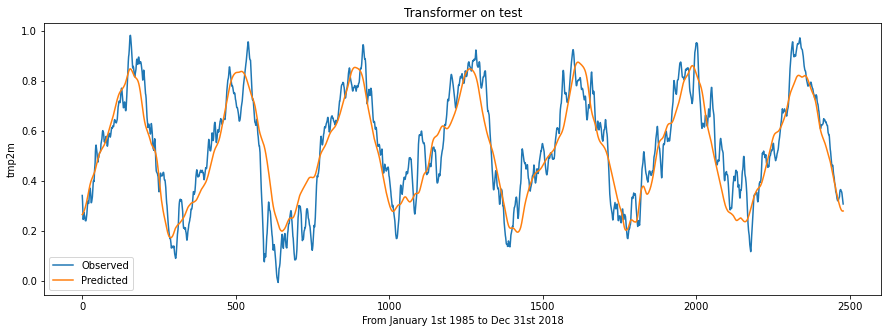

In [54]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test');
# plt.savefig('images/transf_30years_10pc_test.pdf')

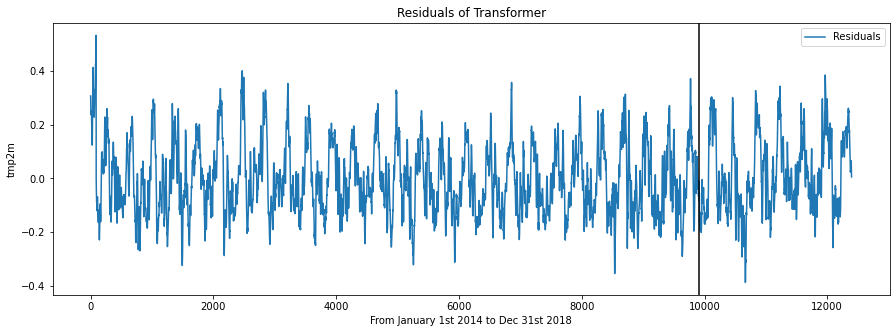

In [51]:
plt.figure(figsize=(15,5))
plt.plot(np.squeeze(y_all) - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer');
plt.axvline(x=X.shape[0]- test_size,c='black');

r-sq on train: 0.8458768118204656
r-sq on test: 0.7795051228879053
cosine_similarity on train: [[0.99007527]]
cosine_similarity on test: [[0.98456565]]


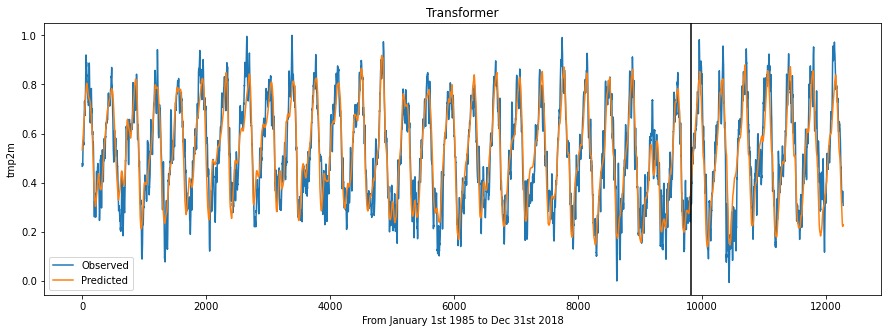

In [57]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [58]:
# torch.save(net.to('cpu'), 'transform_10pc_78.pth')

r-sq on train: 0.8424099791975165
r-sq on test: 0.7598190270938756
cosine_similarity on train: [[0.98987695]]
cosine_similarity on test: [[0.98288254]]


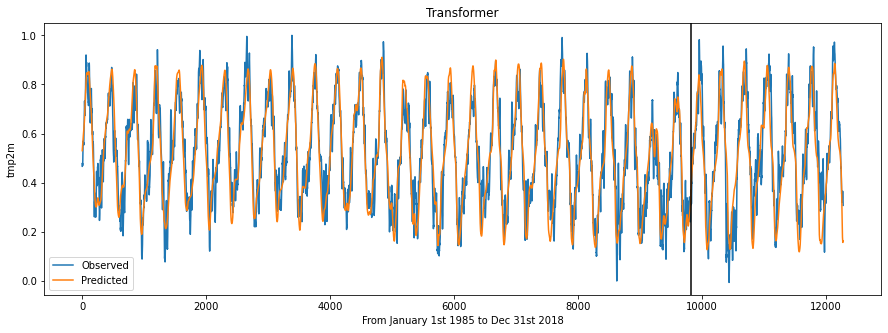

In [52]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.8410631591578355
r-sq on test: 0.7060400868270875
cosine_similarity on train: [[0.98981261]]
cosine_similarity on test: [[0.97872386]]


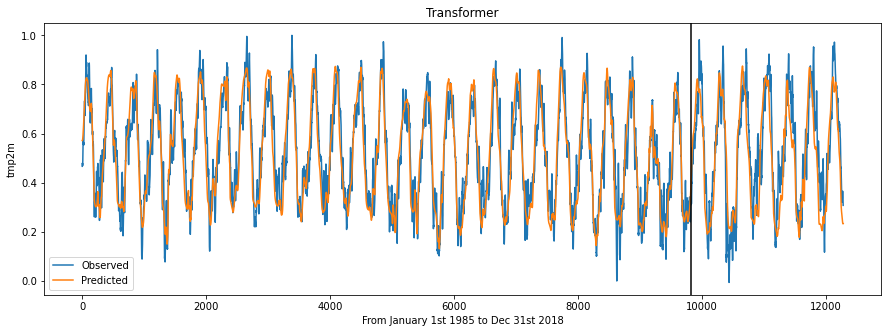

In [218]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

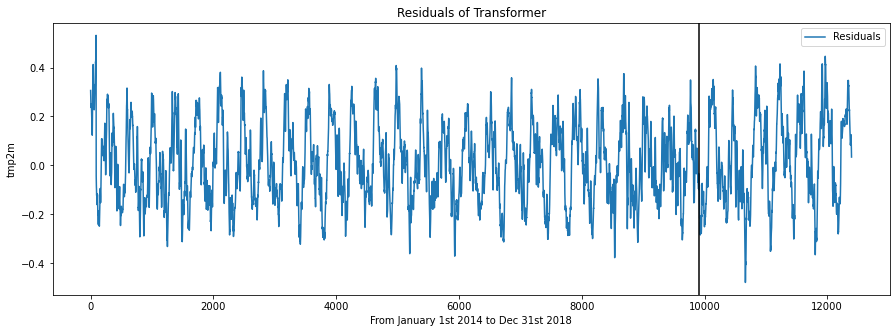

In [219]:
plt.figure(figsize=(15,5))
plt.plot(np.squeeze(y_all) - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer');
plt.axvline(x=X.shape[0]- test_size,c='black');